In [16]:
import numpy as np
from scipy import fftpack
from skimage.metrics import peak_signal_noise_ratio as psnr 

In [17]:
class decoder:
    def __init__(self , alpha = 1 , targetSize=(256, 256)):
        self.alpha = alpha
        self.res = []
        self.targetSize = targetSize
        QUANTIZATION_MATRIX =np.array([
            [16 ,  11 ,   10 ,   16 ,   24 ,   40 ,   51 ,  61],
            [12  , 12  ,  14  ,  19  ,  26  ,  58  ,  60  , 55],
            [14  , 13  ,  16  ,  24  ,  40  ,  57  ,  69  , 56],
            [14  , 17  ,  22  ,  29  ,  51  ,  87  ,  80  , 62],
            [18  , 22  ,  37  ,  56  ,  68  , 109  , 103  , 77],
            [24  , 35  ,  55  ,  64  ,  81  , 104  , 113  , 92],
            [49  , 64  ,  78  ,  87  , 103  , 121  , 120  ,101],
            [72  , 92  ,  95  ,  98  , 112  , 100  , 103  , 99]
                ])

        tmp = np.zeros((8,8,3))
        tmp[:,:,0] , tmp[:,:,1] ,tmp[:,:,2] = QUANTIZATION_MATRIX,QUANTIZATION_MATRIX,QUANTIZATION_MATRIX
        self.QUANTIZATION_MATRIX = tmp

   

    def ycbcr2rgb(self,im):
        xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
        rgb = im.astype(np.float)
        rgb[:,:,[1,2]] -= 128
        rgb = rgb.dot(xform.T)
        np.putmask(rgb, rgb > 255, 255)
        np.putmask(rgb, rgb < 0, 0)
        return np.uint8(rgb)

    def idct(self , a):
        return fftpack.idct( fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')


    def reconstructFromBlocks(self , blocks , targetShape = (265,256) , blockSize = 16):
        numOfBlockInCol = int(targetShape[0] / blockSize)
        numOfBlockInRow = int(targetShape[1] / blockSize)

        recoIMG = np.array([])
        
        count = -1 

        for i in range( numOfBlockInCol):
            recoRow = np.array([])
            for j in range(numOfBlockInRow):
                count += 1
                if recoRow.size == 0:
                    recoRow = blocks[i * numOfBlockInRow]
                else:
                    recoRow = np.hstack((recoRow,blocks[count]))
            
            if recoIMG.size == 0:
                recoIMG = recoRow
            else:
                recoIMG = np.vstack((recoIMG,recoRow))

        return recoIMG


    def iframe_decoding(self , coded):
        decoded = np.zeros(coded.shape)
        for i in range(coded.shape[0]):
            tmp = coded[i] * (self.QUANTIZATION_MATRIX * self.alpha)
            # print(tmp.shape)
            decoded[i] = self.ycbcr2rgb(self.idct(tmp))
        # print(decoded.shape, "&&&&&&&&&&&&&&&&")
        return  self.reconstructFromBlocks( decoded , targetShape = self.targetSize , blockSize = 8).astype("uint8")


    def pframe_decoding(self , prev_frame , diffrences , motion_vectors):
        reco_mbs = []
        diffs = []
        for i in range(diffrences.shape[0]):
            aa = np.hstack((self.idct(diffrences[i,0] * (self.QUANTIZATION_MATRIX * self.alpha)) , self.idct(diffrences[i,1]* (self.QUANTIZATION_MATRIX * self.alpha))))
            bb = np.hstack((self.idct(diffrences[i,2] * (self.QUANTIZATION_MATRIX * self.alpha)) , self.idct(diffrences[i,3]* (self.QUANTIZATION_MATRIX * self.alpha))))
            mb_diff = np.vstack(((aa) , (bb)))
            diffs.append(mb_diff)
            # print(motion_vectors[i,0] , mb_diff.shape[0]+motion_vectors[i,0] , motion_vectors[i,1],mb_diff.shape[1]+motion_vectors[i,1])
            tmp = mb_diff + prev_frame[motion_vectors[i,0]:mb_diff.shape[0]+motion_vectors[i,0] , motion_vectors[i,1]:mb_diff.shape[1]+motion_vectors[i,1]]
            reco_mbs.append(tmp)
        
        self.res.append(self.reconstructFromBlocks( np.array(diffs) , targetShape = self.targetSize , blockSize = 16))

        return  self.reconstructFromBlocks( reco_mbs , targetShape = self.targetSize , blockSize = 16).astype("uint8")


    

    def decode_video(self , coded_video):
        decoded_video = []
        decoded_video.append(self.iframe_decoding(coded_video[0]))
        for i in range(1,coded_video.shape[0]):
            print("++ decoding frame" , i)
            decoded_video.append(self.pframe_decoding(decoded_video[i-1] , coded_video[i][0] , coded_video[i][1]))
        
        return np.array(decoded_video)

        
            


In [18]:
class similarity_method:
    def __init__(self , method="localsearch"):
        self.method = method
        


    def similarity(self, im , block , i=0 , j=0 , r = 5):
        # print("simmmm ",self.method == "fullsearch",self.method ,  "fullsearch" )
        if self.method == "fullsearch":
            return self.fullsearch(im , block)
        
        if self.method == "localsearch":
            return self.localsearch(im , block , i , j , r)




    def fullsearch(self, im , block):
        max_psnr = -1
        maxi = -1
        maxj = -1
        diff =  block - block
        bsize = block.shape[0]
        for i in range(0 , im.shape[0]-bsize , 3):
            # print( max_psnr)
            for j in range(0 , im.shape[1] - bsize , 3):
                s = psnr(im[i:i+bsize , j:j+bsize] , block)
                if s  >= max_psnr:
                    max_psnr = s
                    maxi = i
                    maxj = j
                    diff =  block  -  im[i:i+bsize , j:j+bsize] 
                    
        return diff , [maxi , maxj]   # return upper left corner 



    def localsearch(self , im , block , iii , jjj , radius = 5):
        max_psnr = -1
        maxi = -1
        maxj = -1
        diff =  block - block
        bsize = block.shape[0]

        ui = max(0, iii - radius )  # up of rows
        di = min(im.shape[0], iii + bsize + radius ) # down of rows
        uj = max(0, jjj - radius )  # up of cols
        dj = min(im.shape[1], jjj + bsize + radius )  # down of cols

        for i in range(ui , di - bsize ):
            # print( max_psnr)
            for j in range(uj , dj - bsize ):
                s = psnr(im[i:i+bsize , j:j+bsize] , block)
                if s  >= max_psnr:
                    max_psnr = s
                    maxi = i
                    maxj = j
                    # print( i,j,"     ", maxi , maxj)
                    diff =  block  -  im[i:i+bsize , j:j+bsize] 

        # print(max_psnr)
                    
        return diff , [maxi , maxj]   # return upper left corner 







class encoder:




    def __init__(self ,video ,search_method="localsearch" ,   mb_size = 16 , alpha=1 ):
        self.iframe = video[0]
        self.pframes = video[1:]
        self.mb_size = mb_size
        self.alpha = alpha
        self.sim_method = similarity_method(method=search_method)
        self.decoderr = decoder(targetSize=(144,176))

        QUANTIZATION_MATRIX =np.array([
            [16 ,  11 ,   10 ,   16 ,   24 ,   40 ,   51 ,  61],
            [12  , 12  ,  14  ,  19  ,  26  ,  58  ,  60  , 55],
            [14  , 13  ,  16  ,  24  ,  40  ,  57  ,  69  , 56],
            [14  , 17  ,  22  ,  29  ,  51  ,  87  ,  80  , 62],
            [18  , 22  ,  37  ,  56  ,  68  , 109  , 103  , 77],
            [24  , 35  ,  55  ,  64  ,  81  , 104  , 113  , 92],
            [49  , 64  ,  78  ,  87  , 103  , 121  , 120  ,101],
            [72  , 92  ,  95  ,  98  , 112  , 100  , 103  , 99]
                ])

        tmp = np.zeros((8,8,3))
        tmp[:,:,0] , tmp[:,:,1] ,tmp[:,:,2] = QUANTIZATION_MATRIX,QUANTIZATION_MATRIX,QUANTIZATION_MATRIX
        self.QUANTIZATION_MATRIX = tmp

    def blocking(self, im , blockSize):
        blocks = []
        for i in range(blockSize , im.shape[0]+1 ,blockSize):
            for j in range(blockSize ,im.shape[1]+1 , blockSize):
                B = im[i-blockSize:i , j-blockSize:j]
                blocks.append(B)

        blocks = np.array(blocks)
        return blocks


    def rgb2ycbcr(self , im):
        xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
        ycbcr = im.dot(xform.T)
        ycbcr[:,:,[1,2]] += 128
        return np.uint8(ycbcr)


    def dct(self , a):
        return fftpack.dct( fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )



    def iframe_coding(self):
        mbs = self.blocking(self.iframe , 8)
        coded = np.zeros(mbs.shape)
        for i in range(mbs.shape[0]):
            coded[i] = self.dct(self.rgb2ycbcr(mbs[i]))  /  (self.QUANTIZATION_MATRIX * self.alpha)
        return coded.astype(int)

    

    def pframe_coding(self , frame , prev_reco_frame):
        mbs = self.blocking(frame , 16)
        motion_vectors = []
        diffrences = []
        # print("@@@@@@@@@@@@@" , mbs.shape)
        for i in range(mbs.shape[0]):
            ii = ((i * 16 ) //  prev_reco_frame.shape[1]) * 16
            jj = (i * 16 ) %  prev_reco_frame.shape[1]
            dif , mv = self.sim_method.similarity( prev_reco_frame , mbs[i] ,ii , jj , 5 )
            tmp = self.blocking(dif , 8)  
            a = self.dct(tmp[0] ) /  (self.QUANTIZATION_MATRIX * self.alpha)
            b = self.dct(tmp[1])  /  (self.QUANTIZATION_MATRIX * self.alpha)
            c = self.dct(tmp[2])  /  (self.QUANTIZATION_MATRIX * self.alpha)
            d = self.dct(tmp[3])  /  (self.QUANTIZATION_MATRIX * self.alpha)
            diffrences.append([a,b,c,d])
            motion_vectors.append(mv)
        diffrences = np.array(diffrences)
        motion_vectors = np.array(motion_vectors)

        return diffrences , motion_vectors

    
    def encode_video(self):
        coded_video = []
        iframe_coded = self.iframe_coding()
        coded_video.append(iframe_coded)
        decodedFrame = self.decoderr.iframe_decoding(iframe_coded)
        for i in range(self.pframes.shape[0]):
            print("-- encoding frame",i)
            coded_pframe = self.pframe_coding(self.pframes[i] , decodedFrame)
            coded_video.append(coded_pframe)
            decodedFrame = self.decoderr.pframe_decoding(decodedFrame , coded_pframe[0] , coded_pframe[1])

        return np.array(coded_video)
            



In [19]:
import skvideo as vi
import skvideo.io
import skvideo.motion
import skvideo.measure
import skvideo.datasets
import matplotlib.pyplot as plt
import cv2


raw_suzie = vi.io.vread("suzie_qcif.y4m",as_grey=False)

print(raw_suzie.shape)

(150, 144, 176, 3)


In [20]:
enc = encoder(raw_suzie ,search_method="localsearch" , mb_size=16)

coded_suzie = enc.encode_video()


C:\Users\Farhad\AppData\Local\Temp\ipykernel_10388\329809418.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rgb = im.astype(np.float)


-- encoding frame 0
-- encoding frame 1
-- encoding frame 2
-- encoding frame 3
-- encoding frame 4
-- encoding frame 5
-- encoding frame 6
-- encoding frame 7
-- encoding frame 8
-- encoding frame 9
-- encoding frame 10
-- encoding frame 11
-- encoding frame 12
-- encoding frame 13
-- encoding frame 14
-- encoding frame 15
-- encoding frame 16
-- encoding frame 17
-- encoding frame 18
-- encoding frame 19
-- encoding frame 20
-- encoding frame 21
-- encoding frame 22
-- encoding frame 23
-- encoding frame 24
-- encoding frame 25
-- encoding frame 26
-- encoding frame 27
-- encoding frame 28
-- encoding frame 29
-- encoding frame 30
-- encoding frame 31
-- encoding frame 32
-- encoding frame 33
-- encoding frame 34
-- encoding frame 35
-- encoding frame 36
-- encoding frame 37
-- encoding frame 38
-- encoding frame 39
-- encoding frame 40
-- encoding frame 41
-- encoding frame 42
-- encoding frame 43
-- encoding frame 44
-- encoding frame 45
-- encoding frame 46
-- encoding frame 47
--

C:\Users\Farhad\AppData\Local\Temp\ipykernel_10388\3193844940.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(coded_video)


In [21]:
dec = decoder(targetSize=(raw_suzie.shape[1], raw_suzie.shape[2]))
decoded_suzie = dec.decode_video(coded_suzie)





C:\Users\Farhad\AppData\Local\Temp\ipykernel_10388\329809418.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rgb = im.astype(np.float)


++ decoding frame 1
++ decoding frame 2
++ decoding frame 3
++ decoding frame 4
++ decoding frame 5
++ decoding frame 6
++ decoding frame 7
++ decoding frame 8
++ decoding frame 9
++ decoding frame 10
++ decoding frame 11
++ decoding frame 12
++ decoding frame 13
++ decoding frame 14
++ decoding frame 15
++ decoding frame 16
++ decoding frame 17
++ decoding frame 18
++ decoding frame 19
++ decoding frame 20
++ decoding frame 21
++ decoding frame 22
++ decoding frame 23
++ decoding frame 24
++ decoding frame 25
++ decoding frame 26
++ decoding frame 27
++ decoding frame 28
++ decoding frame 29
++ decoding frame 30
++ decoding frame 31
++ decoding frame 32
++ decoding frame 33
++ decoding frame 34
++ decoding frame 35
++ decoding frame 36
++ decoding frame 37
++ decoding frame 38
++ decoding frame 39
++ decoding frame 40
++ decoding frame 41
++ decoding frame 42
++ decoding frame 43
++ decoding frame 44
++ decoding frame 45
++ decoding frame 46
++ decoding frame 47
++ decoding frame 48
+

In [22]:
size = (raw_suzie.shape[2], raw_suzie.shape[1])
time = 6
fps = int(raw_suzie.shape[0] / time)

out = cv2.VideoWriter('decoded_localsearch.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, size)
i = 0 
for f in decoded_suzie:
    # print(f.shape)
    out.write(np.array(cv2.cvtColor(f, cv2.COLOR_RGB2BGR)).astype(dtype=np.uint8) )
out.release() 

In [23]:
def show_motion_vectors(motions ,frameSize =(144,176) ,  bsize = 16):
    a = []
    b = []
    c = []
    d = []
    for i in range(motions.shape[0]):
        ii = ((i * bsize ) //  frameSize[1]) * bsize
        jj = (i * bsize ) %  frameSize[1]
        a.append(motions[i][0])
        b.append(motions[i][1])
        c.append(ii - motions[i][0])
        d.append(jj - motions[i][1])
    
    

    plt.quiver(a,b,c,d, angles='xy', scale_units='xy', scale=1)
    # plt.xlim(0, frameSize[1])
    # plt.ylim(0, frameSize[0] )
    plt.show()
    



In [25]:
np.array(dec.res).shape

(149, 144, 176, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


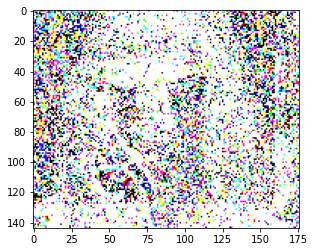

In [52]:
plt.imshow(np.array(dec.res)[10] )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


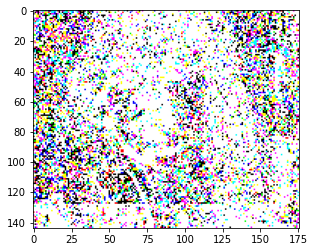

In [53]:
plt.imshow(np.array(dec.res)[11])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


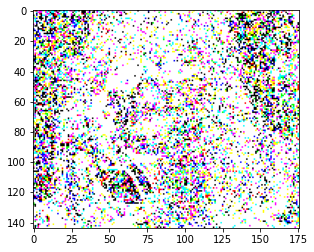

In [54]:
plt.imshow(np.array(dec.res)[12])

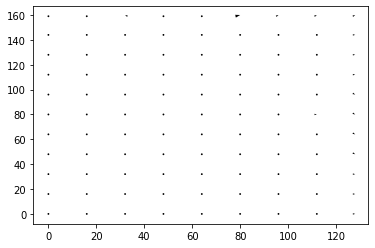

In [46]:
show_motion_vectors(coded_suzie[10][1])

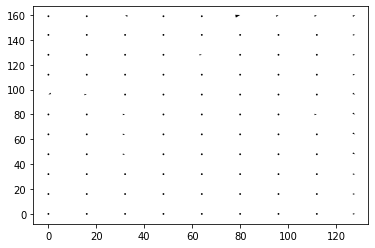

In [47]:
show_motion_vectors(coded_suzie[11][1])

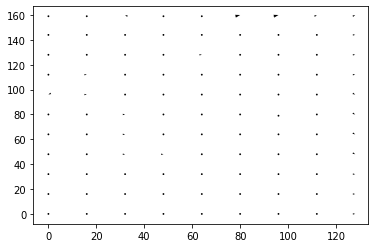

In [45]:
show_motion_vectors(coded_suzie[12][1])

In [6]:
enc = encoder(raw_suzie ,search_method="localsearch" , mb_size=16)
codedd = enc.iframe_coding()

# a = enc.rgb2ycbcr(raw_suzie[0])
codedd.shape

(396, 8, 8, 3)

In [7]:
decoder1 = decoder(targetSize=(144,176))

decodedIframe = decoder1.iframe_decoding(codedd)


C:\Users\Farhad\AppData\Local\Temp\ipykernel_10388\2425302707.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rgb = im.astype(np.float)


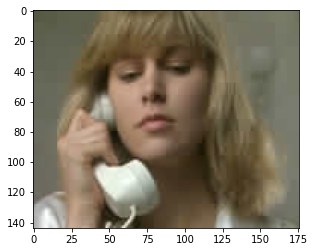

In [8]:
plt.imshow(decodedIframe)

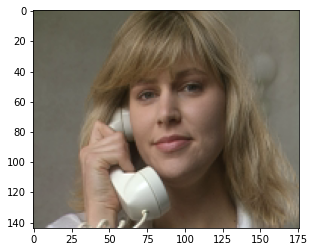

In [9]:
plt.imshow(raw_suzie[100] )

In [10]:
coded_pframe = enc.pframe_coding(raw_suzie[10] , decodedIframe)

In [11]:
coded_pframe[0].shape

(99, 4, 8, 8, 3)

In [12]:
decoded_pframe = decoder1.pframe_decoding(decodedIframe , coded_pframe[0] , coded_pframe[1])

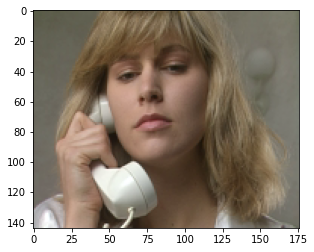

In [13]:
plt.imshow(decoded_pframe)

In [14]:
psnr(decoded_pframe , raw_suzie[100])

15.560683601986572

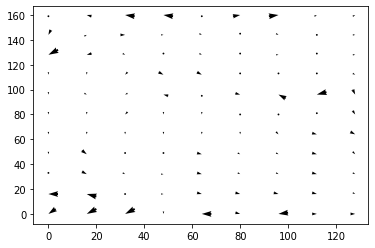

In [48]:
show_motion_vectors( coded_pframe[1])